# 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
import contractions
from unidecode import unidecode
import re, string
from collections import Counter

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
stop_words = stopwords.words('english')

In [3]:
print('not' in stop_words)

True


# 2. Load dataset and Exploratory Data Analysis (EDA)
In this step, we will load the dataset and perform some exploratory data analysis to understand the data better.

In [4]:
dataframe = pd.read_csv('../Resources/Dataset/IMDB_Dataset.csv')
dataframe.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

As we can see, the dataset have two columns: review and sentiment. The review column contains the text of the review, and the sentiment column contains the sentiment of the review (positive or negative).

## 2.1 Data distribution

In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
dataframe.describe().T

count unique                                                top  \
review     50000  49582  Loved today's show!!! It was a variety and not...   
sentiment  50000      2                                           positive   

            freq  
review         5  
sentiment  25000

There are 50,000 reviews in the dataset, with an equal number of positive and negative reviews. The dataset does not contain any missing values. The unique values in the sentiment column are 'positive' and 'negative'.

In [7]:
dataframe.isnull().sum()

review       0
sentiment    0
dtype: int64

The dataset does not contain any missing values, so we do not need to handle any missing values in the data.

In [8]:
dataframe['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

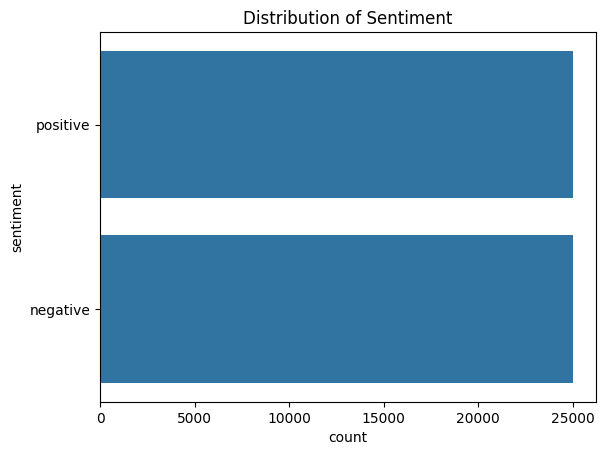

In [9]:
sns.countplot(dataframe['sentiment'])
plt.title('Distribution of Sentiment')
plt.show()

The dataset for sentiment analysis is balanced, with an equal number of positive and negative reviews. The dataset contains 25,000 positive reviews and 25,000 negative reviews.

## 2.2 Average length of reviews

Text(0.5, 1.0, 'Negative reviews')

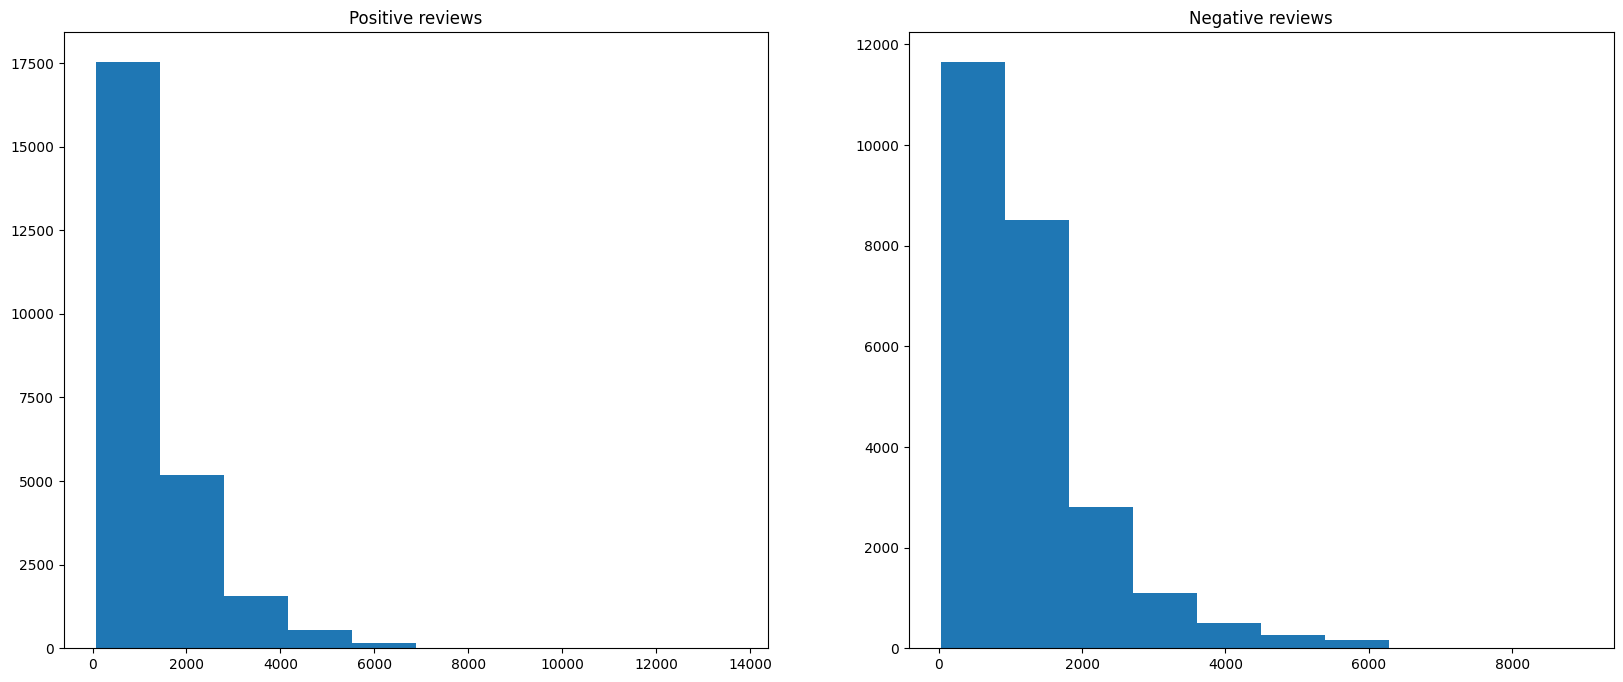

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.hist(dataframe[dataframe['sentiment'] == 'positive']['review'].str.len())
ax1.set_title('Positive reviews')
ax2.hist(dataframe[dataframe['sentiment'] == 'negative']['review'].str.len())
ax2.set_title('Negative reviews')


From the histogram, we can observe some insights:
- The length of reviews for both positive and negative reviews is mostly between 0 and 5000. In general, people comment less word in the positive review than negative reviews.
- However, the length of negative reviews is more varied than positive reviews. It means in some case, people tend to write more words for excellent movies and could less criticise for bad movies.

Next, we're going to do some data preprocessing to clean the text data. We'll make a words cloud to see the most frequent words in large font and least used words in small font  in the positive and negative reviews.

**Note**: 
- Word clouds are a popular way to visualize text data. The size of each word indicates its frequency or importance.
- We need to import the library `WordCloud` to create a word cloud. (as we did in the import library section)


## 2.3 Distribution of word count in reviews

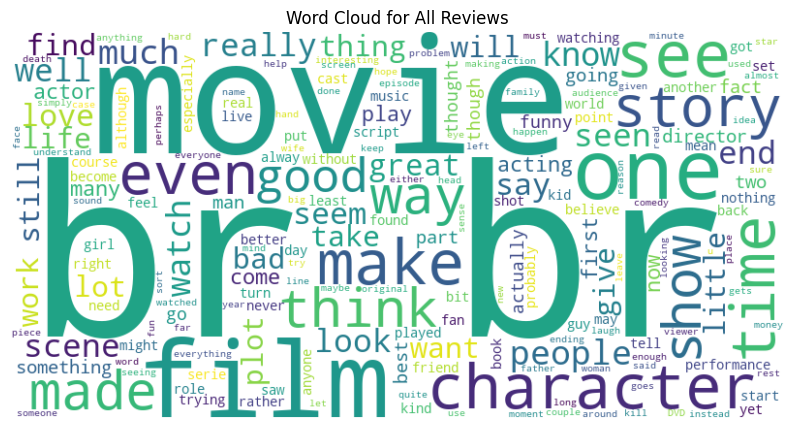

In [11]:
all_reviews = " ".join(review for review in dataframe['review'])
all_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10,6))
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Reviews')

plt.show()

In [12]:
positive_reviews = " ".join(review for review in dataframe[dataframe['sentiment'] == 'positive']['review'])
positive_cloud = WordCloud(background_color='white').generate(positive_reviews)

negative_reviews = " ".join(review for review in dataframe[dataframe['sentiment'] == 'negative']['review'])
negative_cloud = WordCloud(background_color='white').generate(negative_reviews)


Text(0.5, 1.0, 'Word cloud for negative reviews')

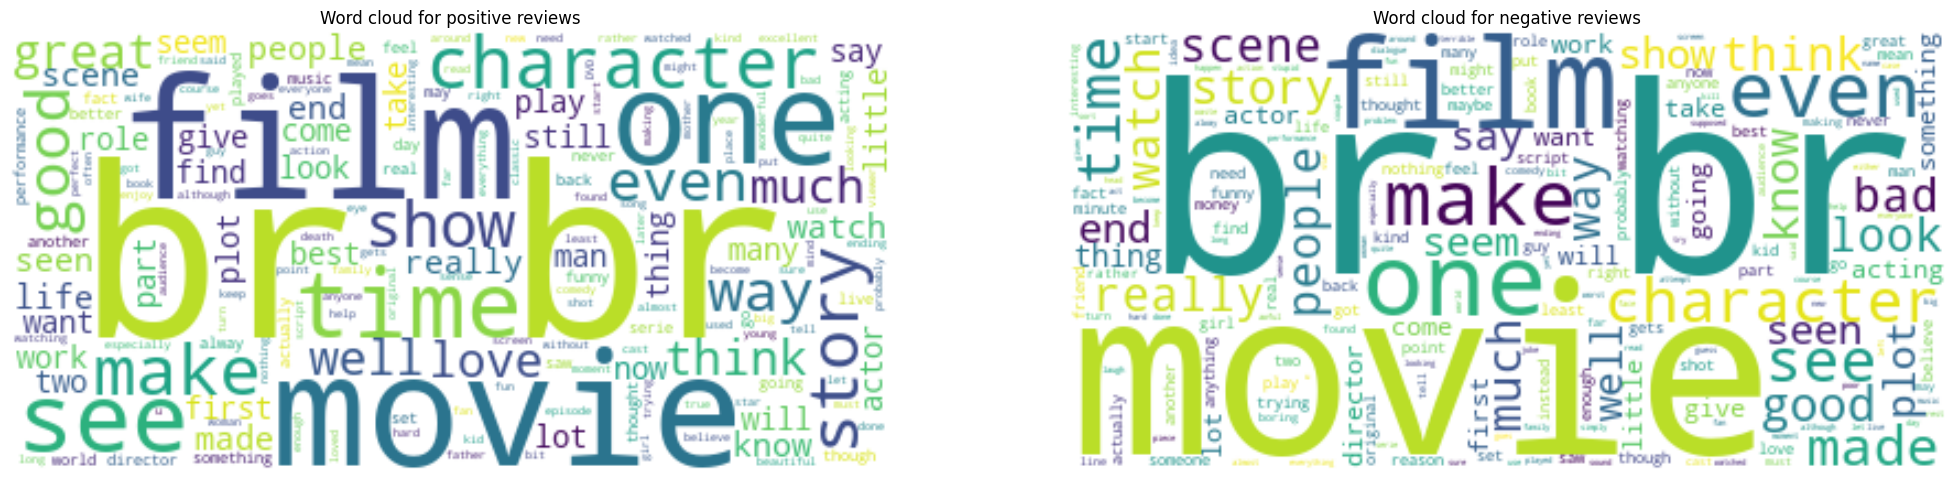

In [13]:
plt.figure(figsize=(25,15))

plt.subplot(1,2,1)
plt.imshow(positive_cloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word cloud for positive reviews")

plt.subplot(1,2,2)
plt.imshow(negative_cloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word cloud for negative reviews")

# 3. Preprocessing

Data preprocessing is a crucial step in any machine learning project. It involves cleaning and transforming the data to make it suitable for building and training machine learning models.

In this section, we will perform the following data preprocessing steps:
- Remove special characters, numbers, and punctuation
- Convert text to lowercase
- Remove URLs, emojis, and emoticons
- Remove stopwords
- Tokenization

## 3.1 Cleaned data

In [14]:
dataframe.rename(columns={'review':'text'}, inplace = True)
dataframe

text sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]

In [15]:
def clean_noise_data(text):
    text = unidecode(text)  
    
    text = text.lower()
    
    text = text.replace("!|s", "'s").replace("!ss", "'")

    text = re.sub(r'https?://\S+|www\.\S+', '', text)
        
    text = re.sub(r'<.*?>+', '', text)

    text = re.sub(r"\b\d+\b", "", text)

    expanded_words = [contractions.fix(word) for word in text.split()]
    text = ' '.join(expanded_words)

    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    
    text = re.sub(r'\n', ' ', text)

    text = re.sub(r'[’“”…]', '', text)

    emoji_pattern = re.compile(r"["  
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text)  

    text = re.sub(r'\s+', ' ', text).strip()

    return text
    

In [16]:
example_text = dataframe['text'][48302]
cleaned_text = clean_noise_data(example_text)

print('Original Text:\n', example_text)
print('\n After Cleaning:\n', cleaned_text)

Original Text:
 October Sky is a highly lauded movie, and it¡¦s easy to see why. The story is easy to comprehend and many turning points are gripping, the actors and actresses do fairly good jobs, especially Jake Gyllenhaal and Chris Cooper, the hero finally gets what he wants, and it¡¦s a true story. Frankly I think the director¡¦s achievement is not comparable to the sparks and heat the original story generates. We don¡¦t see any special narrative or cinematography; the power of the movie relies much on the riveting plot and tough situation the young hero is trapped in that most audience will find themselves identify with the characters. We feel Homer¡¦s desire to earn his father¡¦s recognition and create his own future, and his resilience wins our respect. ¡§October Sky¡¨ reminds me of a later 2001 Japanese production of mini series ¡§Rocket Boy,¡¨ which might owe some of the inspiration from this movie. Actually these two works shot from two different cultures provide interesting c

In [17]:
cleaned_data = dataframe['text'].apply(lambda x: clean_noise_data(x))

In [18]:
cleaned_data

0        one of the other reviewers has mentioned that ...
1        a wonderful little production the filming tech...
2        i thought this was a wonderful way to spend ti...
3        basically there is a family where a little boy...
4        petter mattei s love in the time of money is a...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    i am a catholic taught in parochial elementary...
49998    i am going to have to disagree with the previo...
49999    no one expects the star trek movies to be high...
Name: text, Length: 50000, dtype: object

We have cleaned the text data by removing special characters, numbers, punctuation, URLs, emojis, and emoticons to ensure consistency and readability. Additionally, we standardized the text by replacing short forms with their full versions to improve comprehension.
Because the data after removed is pandas Series objects, we need to convert it to a data frame before we start removing stopwords.

In [19]:
type(cleaned_data)

pandas.core.series.Series

In [20]:
cleaned_df = cleaned_data.to_frame(name='text')
cleaned_df['sentiment'] = dataframe['sentiment']

In [21]:
cleaned_df

text sentiment
0      one of the other reviewers has mentioned that ...  positive
1      a wonderful little production the filming tech...  positive
2      i thought this was a wonderful way to spend ti...  positive
3      basically there is a family where a little boy...  negative
4      petter mattei s love in the time of money is a...  positive
...                                                  ...       ...
49995  i thought this movie did a down right good job...  positive
49996  bad plot bad dialogue bad acting idiotic direc...  negative
49997  i am a catholic taught in parochial elementary...  negative
49998  i am going to have to disagree with the previo...  negative
49999  no one expects the star trek movies to be high...  negative

[50000 rows x 2 columns]

## 3.2 Remove stopwords
**Why we need to remove stoptwords?**
- **Focus on meaningful content**: Stop words (e.g., "and," "the," "is") do not carry significant meaning for the sentiment of a text. They are common words that don't add to the positive or negative tone of a sentence. By removing them, you focus on the more relevant words that actually contribute to the sentiment
- **Reduce noise**: Including stop words can introduce noise in your data, making the model less efficient. By removing them, you clean the data, reducing irrelevant information.
- **Improved performance**: With fewer words in the dataset, computations become faster and more efficient, leading to better model performance and reduced memory usage.
- **Enhanced accuracy**: Stop words can dilute the signal in sentiment analysis. Removing them allows the model to focus on more influential words, improving the accuracy of your sentiment predictions.

**How to remove stopwords?**
- We can use the `nltk` library to remove stopwords from the text data. The `nltk` library provides a list of stopwords in different languages, which we can use to filter out these words from the text data.

In [22]:
cleaned_df['no_sw'] = cleaned_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

In [23]:
cleaned_df

text sentiment  \
0      one of the other reviewers has mentioned that ...  positive   
1      a wonderful little production the filming tech...  positive   
2      i thought this was a wonderful way to spend ti...  positive   
3      basically there is a family where a little boy...  negative   
4      petter mattei s love in the time of money is a...  positive   
...                                                  ...       ...   
49995  i thought this movie did a down right good job...  positive   
49996  bad plot bad dialogue bad acting idiotic direc...  negative   
49997  i am a catholic taught in parochial elementary...  negative   
49998  i am going to have to disagree with the previo...  negative   
49999  no one expects the star trek movies to be high...  negative   

                                                   no_sw  
0      one reviewers mentioned watching oz episode ho...  
1      wonderful little production filming technique ...  
2      thought wonderful way spend time hot summer we...  
3      basically family little boy jake thinks zombie...  
4      petter mattei love time money visually stunnin...  
...                                                  ...  
49995  thought movie right good job creative original...  
49996  bad plot bad dialogue bad acting idiotic direc...  
49997  catholic taught parochial elementary schools n...  
49998  going disagree previous comment side maltin on...  
49999  one expects star trek movies high art fans exp...  

[50000 rows x 3 columns]

In [24]:
print('Original Text:\n', cleaned_df['text'][9])
print('\n')
print('After remove stopwords:\n', cleaned_df['no_sw'][9])

Original Text:
 if you like original gut wrenching laughter you will like this movie if you are young or old then you will love this movie hell even my mom liked it great camp


After remove stopwords:
 like original gut wrenching laughter like movie young old love movie hell even mom liked great camp


After removing the stopwords, the text data is now cleaner and more focused on the meaningful content. The removal of stopwords helps to reduce noise in the data and improve the efficiency of the model by focusing on the most relevant words that contribute to the sentiment of the reviews.

Now we will visualize the most frequent words in the cleaned text data using a word cloud to gain insights into the sentiment of the reviews after preprocessing.

## 3.3 Visualize data after preprocessing

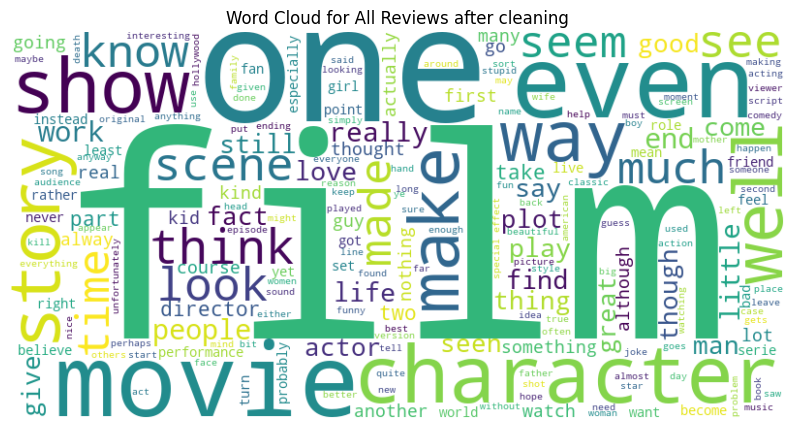

In [25]:
all_reviews = " ".join(review for review in cleaned_df['no_sw'])
all_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Reviews after cleaning')
plt.show()

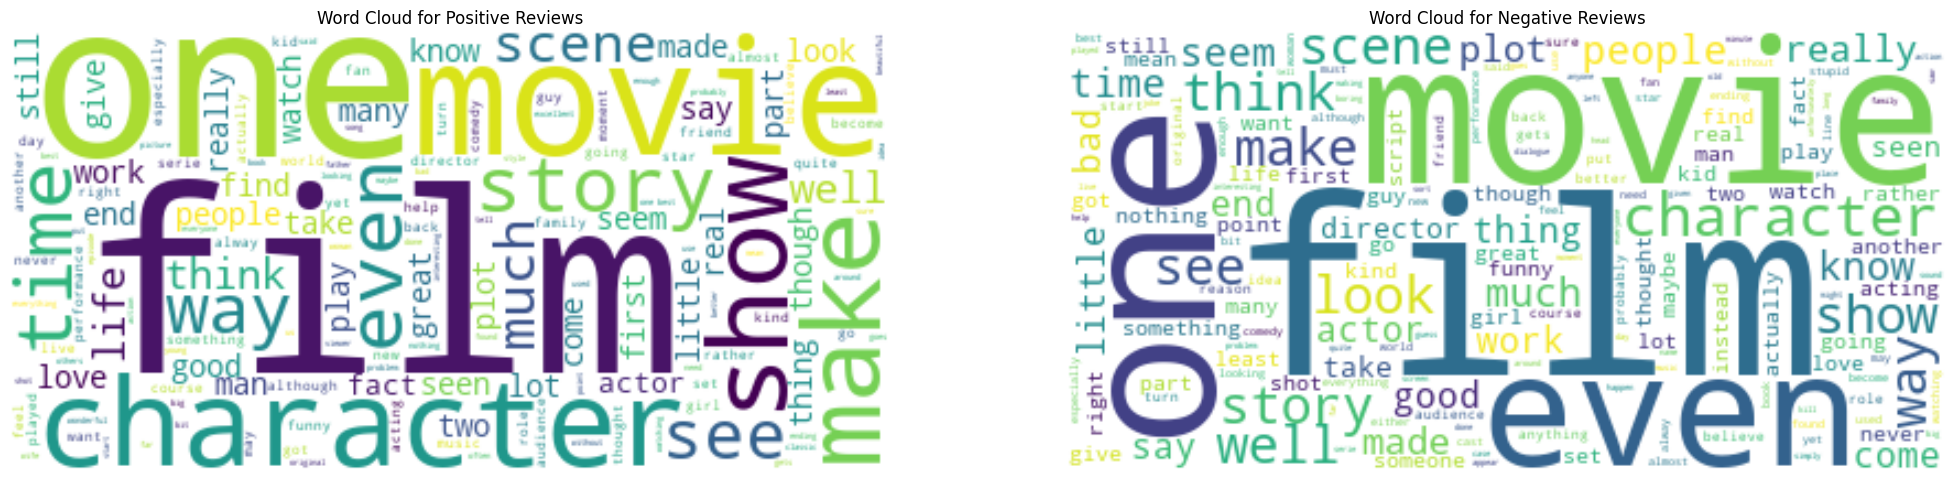

In [26]:
positive_reviews = " ".join(review for review in cleaned_df[cleaned_df['sentiment'] == "positive"]['no_sw'])
positive_wordcloud = WordCloud(background_color='white').generate(positive_reviews)

negative_reviews = " ".join(review for review in cleaned_df[cleaned_df['sentiment'] == "negative"]['no_sw'])
negative_wordcloud = WordCloud(background_color='white').generate(negative_reviews)

plt.figure(figsize=(25, 15))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')

plt.show()

We can see that the word clouds for positive and negative reviews show the most frequent words in the text data. The size of each word indicates its frequency in the reviews. The word clouds provide insights into the sentiment of the reviews and help identify the most common words used in positive and negative reviews. But we can see that the most frequent words are not very informative.

Next, we need to find most frequent words in the positive and negative reviews. Then we remove they from the text data.

Why we need to remove the most frequent words?

Removing Noise: Frequent words are often generic and carry little meaningful information about the specific context of the text. For example, words like "the", "is", or "in" are common in many documents but don't help in distinguishing one text from another. These words are known as stopwords, and even after stopword removal, other domain-specific or overly common words may still dominate the dataset.
Improving Model Performance: By removing the most frequent words, you can reduce the noise in the dataset. This allows the model to focus on the more relevant words that contribute to the sentiment, leading to more accurate predictions.
Enhancing Topic Discovery: In tasks like topic modeling or clustering, the most frequent words might overshadow the more meaningful terms. Removing these frequent words allows the algorithm to uncover hidden patterns and topics in the data.
Handling Sparsity: Highly frequent words tend to dominate the feature space, which can cause sparsity issues in some models (especially in count-based models like Bag of Words). Removing them helps in balancing the feature space.

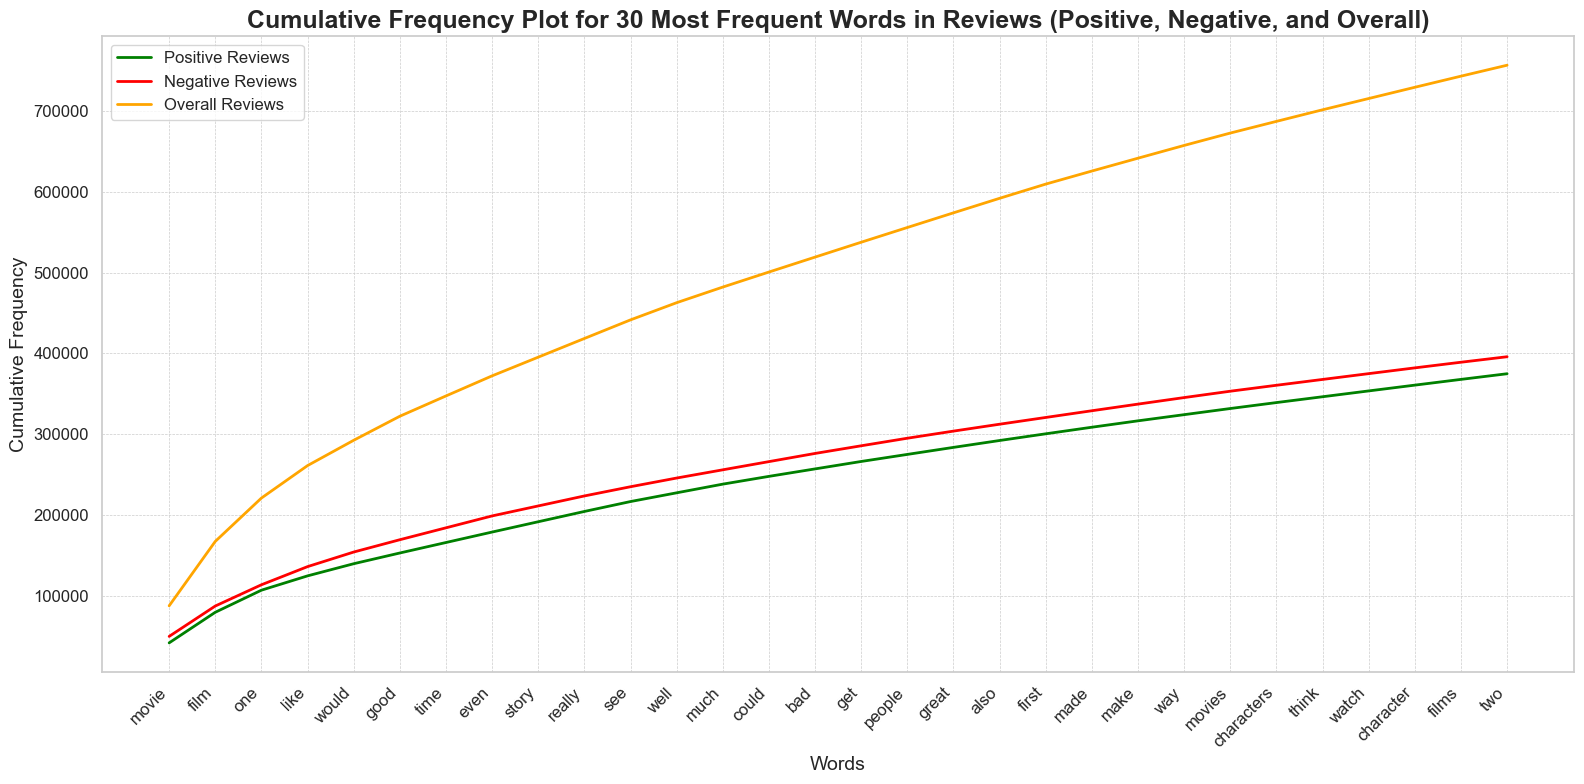

In [27]:
sns.set(style="whitegrid")

positive_reviews = cleaned_df[cleaned_df['sentiment'] == "positive"]['no_sw']
negative_reviews = cleaned_df[cleaned_df['sentiment'] == "negative"]['no_sw']
all_reviews = cleaned_df['no_sw']

positive_words = ' '.join(positive_reviews).split()
negative_words = ' '.join(negative_reviews).split()
all_words = ' '.join(all_reviews).split()

positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)
all_word_freq = Counter(all_words)

positive_most_common = positive_word_freq.most_common(30)
negative_most_common = negative_word_freq.most_common(30)
all_most_common = all_word_freq.most_common(30)

positive_words, positive_frequencies = zip(*positive_most_common)
negative_words, negative_frequencies = zip(*negative_most_common)
all_words, all_frequencies = zip(*all_most_common)

plt.figure(figsize=(16, 8))
plt.title('Cumulative Frequency Plot for 30 Most Frequent Words in Reviews (Positive, Negative, and Overall)', 
          fontsize=18, weight='bold')
plt.xlabel('Words', fontsize=14)
plt.ylabel('Cumulative Frequency', fontsize=14)

plt.plot(range(1, 31), np.cumsum(positive_frequencies), label='Positive Reviews', color='green', linewidth=2)
plt.plot(range(1, 31), np.cumsum(negative_frequencies), label='Negative Reviews', color='red', linewidth=2)
plt.plot(range(1, 31), np.cumsum(all_frequencies), label='Overall Reviews', color='orange', linewidth=2)

plt.xticks(ticks=range(1, 31), labels=all_words, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

plt.show()


### Analysis of the Chart:

This cumulative frequency plot highlights the 30 most frequent words used in reviews, divided into:

- **Positive Reviews** (green line)
- **Negative Reviews** (red line)
- **Overall Reviews** (yellow line)

---

### Key Insights from the Chart

#### **Overall Word Usage**
The **yellow line** (overall reviews) shows the highest cumulative frequency for each word, which is expected as it aggregates words from both positive and negative reviews. Its steep upward trajectory reflects the universal significance of common terms like **"movie," "film,"** and **"one."**

#### **Positive vs. Negative Reviews**
- **Negative Reviews** (red line) exhibit consistently higher cumulative frequencies compared to **Positive Reviews** (green line). 
- This may indicate that negative reviews tend to use more of these frequent words, suggesting a tendency toward lengthier or more detailed feedback in negative contexts.

#### **Frequently Used Words**
- Words like **"movie," "film," "one," "time,"** and **"not"** dominate across all categories, highlighting their centrality to review content regardless of sentiment.
- Negative reviews are more likely to feature terms like **"bad," "could,"** and **"not,"** reflecting their critical nature.
- Conversely, positive reviews include terms such as **"great"** and **"good"** but with less dominance compared to the negative counterparts.

#### **Tone and Vocabulary Patterns**
- The **gradual slope of the green line** (positive reviews) suggests a broader variety of words used when expressing praise, compared to the **sharper rise of the red line** (negative reviews), which indicates repetitive vocabulary in criticism.
- Negative reviews may emphasize dissatisfaction with commonly criticized elements like **"movie"** or **"bad,"** whereas positive reviews might involve more nuanced praise spread across a wider lexicon.


## 3.4 Remove less informative words in data

In [28]:
def find_most_frequent_words(df, column_name, top_n=10):
    counter = Counter()
    for text in df[column_name].values:
        for word in text.split():
            counter[word] += 1
    most_common_words = counter.most_common(top_n)
    return pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

In [29]:
most_common = find_most_frequent_words(cleaned_df, 'no_sw', 30)

print("Most Frequent Words:\n")
print(most_common.to_string(index=False))

Most Frequent Words:

      Word  Frequency
     movie      87925
      film      79661
       one      53580
      like      40154
     would      31293
      good      29737
      time      25093
      even      24850
     story      23109
    really      23089
       see      23020
      well      21246
      much      19312
     could      18599
       bad      18459
       get      18412
    people      18198
     great      18137
      also      17972
     first      17571
      made      16150
      make      15891
       way      15778
    movies      15296
characters      14443
     think      14335
     watch      13935
 character      13898
     films      13748
       two      13541


In [30]:
FREQWORDS = {'movie', 'film', 'one', 'would', 'time', 'even', 'story', 'see', 'could', 'get', 'people', 'made', 'make', 'way', 'movies', 'characters', 'character', 'films', 'two', 'think', 'watch', 'also', 'show', 'scene', 'look'}
print(FREQWORDS)

{'character', 'even', 'films', 'story', 'could', 'get', 'show', 'make', 'made', 'see', 'two', 'one', 'scene', 'film', 'way', 'movies', 'think', 'characters', 'movie', 'also', 'look', 'watch', 'would', 'people', 'time'}


In [31]:
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

In [32]:
cleaned_df['no_sw_mostfreq'] = cleaned_df['no_sw'].apply(remove_freqwords)

In [33]:
print('Original Text:\n', dataframe['text'][49996])
print('\n')
print('Cleaned Text:\n', cleaned_df['no_sw_mostfreq'][49996])

Original Text:
 Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ran continually over the overacted script, and a crappy copy of the VHS cannot be redeemed by consuming liquor. Trust me, because I stuck this turkey out to the end. It was so pathetically bad all over that I had to figure it was a fourth-rate spoof of Springtime for Hitler.<br /><br />The girl who played Janis Joplin was the only faint spark of interest, and that was only because she could sing better than the original.<br /><br />If you want to watch something similar but a thousand times better, then watch Beyond The Valley of The Dolls.


Cleaned Text:
 bad plot bad dialogue bad acting idiotic directing annoying porn groove soundtrack ran continually overacted script crappy copy vhs cannot redeemed consuming liquor trust stuck turkey end pathetically bad figure fourth rate spoof springtime hitler girl played janis joplin faint spark interest sing better original want some

## 3.5 Visualize data after preprocessing and removing most frequent words

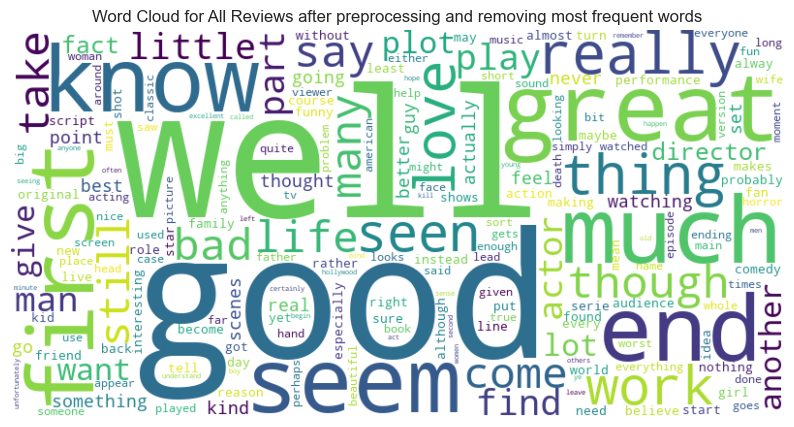

In [34]:
all_reviews = " ".join(review for review in cleaned_df['no_sw_mostfreq'])
all_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Reviews after preprocessing and removing most frequent words')
plt.show()

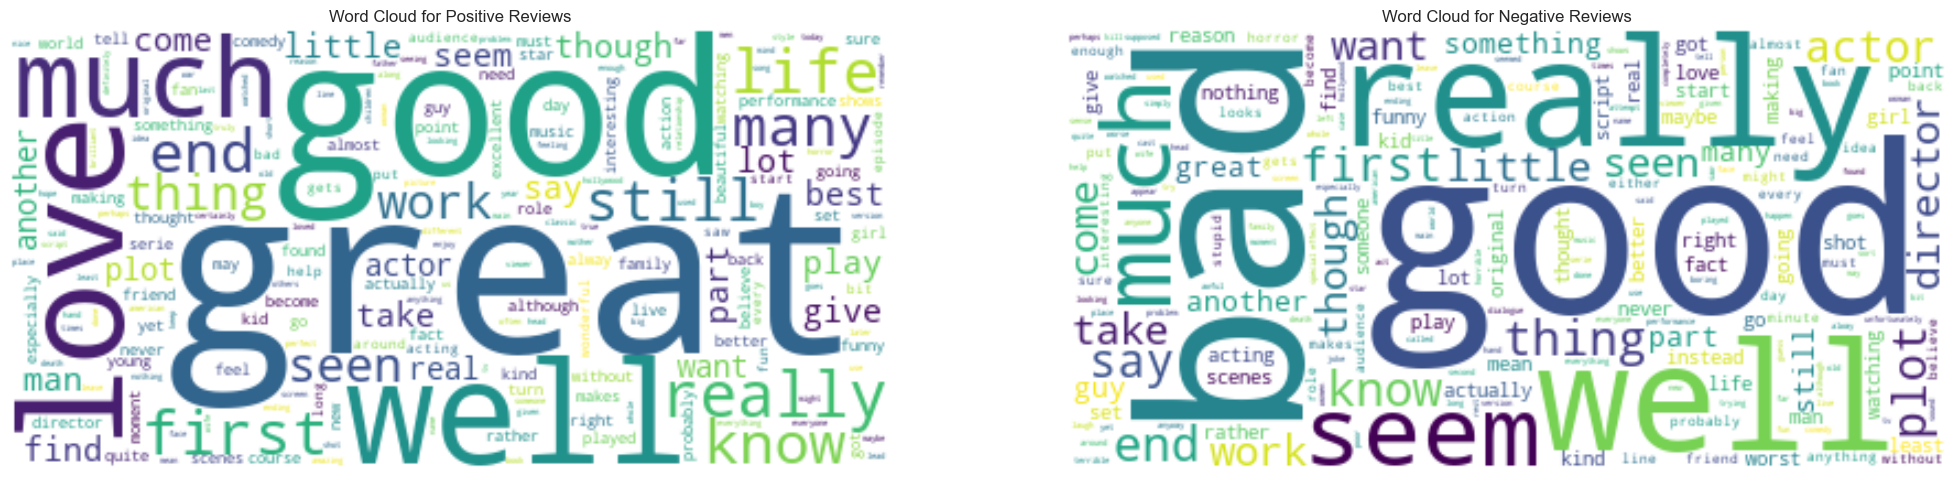

In [35]:
positive_reviews = " ".join(review for review in cleaned_df[cleaned_df['sentiment'] == "positive"]['no_sw_mostfreq'])
positive_wordcloud = WordCloud(background_color='white').generate(positive_reviews)

negative_reviews = " ".join(review for review in cleaned_df[cleaned_df['sentiment'] == "negative"]['no_sw_mostfreq'])
negative_wordcloud = WordCloud(background_color='white').generate(negative_reviews)

plt.figure(figsize=(25, 15))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')

plt.show()

We can see that the dataset is relatively clean, and the key words for both positive and negative sentiments are clearly visible. However, some words, though similar, appear in different forms, such as "good" and "well," which share a similar meaning but differ in structure. To address this, we need to apply a technique to unify word forms, and in this case, we will use Lemmatization.

## 3.6 Lemmatization
**Why use Lemmatization?** <br>
Lemmatization is the process of converting words to their base or root form. It is similar to stemming, but it is more accurate because it considers the context of the word. For example, the word "running" would be converted to "run" using lemmatization. <br>
For example:
- **Stemming**: "running" -> "run"
- **Stemming**: "better" -> "better"
- **Lemmatization**: "running" -> "running"
- **Lemmatization**: "better" -> "good"
- **Lemmatization**: "best" -> "good"

In [36]:
lemmatizer = WordNetLemmatizer()
cleaned_df['lemmatized'] = cleaned_df['no_sw_mostfreq'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [37]:
cleaned_df

text sentiment  \
0      one of the other reviewers has mentioned that ...  positive   
1      a wonderful little production the filming tech...  positive   
2      i thought this was a wonderful way to spend ti...  positive   
3      basically there is a family where a little boy...  negative   
4      petter mattei s love in the time of money is a...  positive   
...                                                  ...       ...   
49995  i thought this movie did a down right good job...  positive   
49996  bad plot bad dialogue bad acting idiotic direc...  negative   
49997  i am a catholic taught in parochial elementary...  negative   
49998  i am going to have to disagree with the previo...  negative   
49999  no one expects the star trek movies to be high...  negative   

                                                   no_sw  \
0      one reviewers mentioned watching oz episode ho...   
1      wonderful little production filming technique ...   
2      thought wonderful way spend time hot summer we...   
3      basically family little boy jake thinks zombie...   
4      petter mattei love time money visually stunnin...   
...                                                  ...   
49995  thought movie right good job creative original...   
49996  bad plot bad dialogue bad acting idiotic direc...   
49997  catholic taught parochial elementary schools n...   
49998  going disagree previous comment side maltin on...   
49999  one expects star trek movies high art fans exp...   

                                          no_sw_mostfreq  \
0      reviewers mentioned watching oz episode hooked...   
1      wonderful little production filming technique ...   
2      thought wonderful spend hot summer weekend sit...   
3      basically family little boy jake thinks zombie...   
4      petter mattei love money visually stunning mr ...   
...                                                  ...   
49995  thought right good job creative original first...   
49996  bad plot bad dialogue bad acting idiotic direc...   
49997  catholic taught parochial elementary schools n...   
49998  going disagree previous comment side maltin se...   
49999  expects star trek high art fans expect good be...   

                                              lemmatized  
0      reviewer mentioned watching oz episode hooked ...  
1      wonderful little production filming technique ...  
2      thought wonderful spend hot summer weekend sit...  
3      basically family little boy jake think zombie ...  
4      petter mattei love money visually stunning mr ...  
...                                                  ...  
49995  thought right good job creative original first...  
49996  bad plot bad dialogue bad acting idiotic direc...  
49997  catholic taught parochial elementary school nu...  
49998  going disagree previous comment side maltin se...  
49999  expects star trek high art fan expect good bes...  

[50000 rows x 5 columns]

In [38]:
print('Cleaned Text:\n', cleaned_df['no_sw_mostfreq'][1005])
print('\n')
print('Lemmatized Text:\n', cleaned_df['lemmatized'][1005])

Cleaned Text:
 bad dialogues actors actresses everything hard imagine worse year following years love brother set australia among italian immigrants nothing shallow cliches italian culture offer quite telling italians italy speak english message ugly marry ugly beautiful marry beautiful truly discomforting giovanni ribisi quite good like suburbia lost translation pseudo italian accent hard bear risk trash trash


Lemmatized Text:
 bad dialogue actor actress everything hard imagine worse year following year love brother set australia among italian immigrant nothing shallow cliche italian culture offer quite telling italian italy speak english message ugly marry ugly beautiful marry beautiful truly discomforting giovanni ribisi quite good like suburbia lost translation pseudo italian accent hard bear risk trash trash


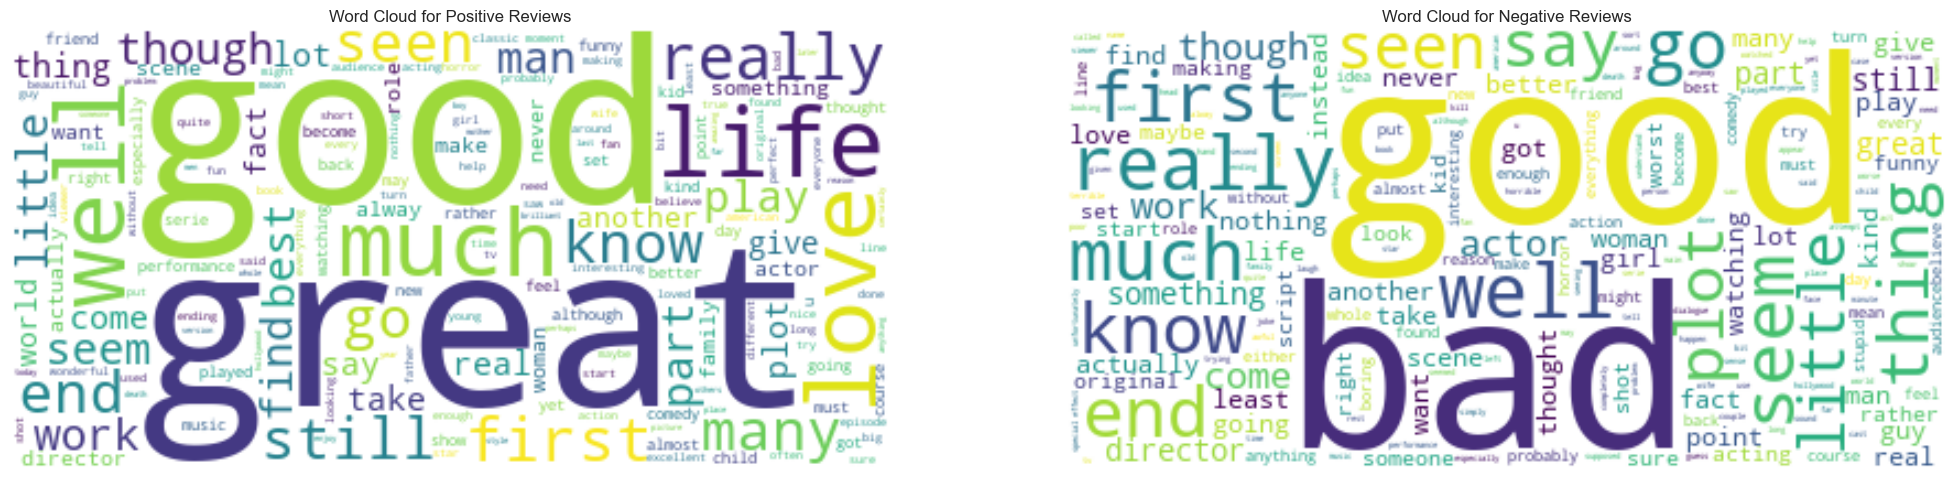

In [39]:
positive_reviews = " ".join(review for review in cleaned_df[cleaned_df['sentiment'] == "positive"]['lemmatized'])
positive_wordcloud = WordCloud(background_color='white').generate(positive_reviews)

negative_reviews = " ".join(review for review in cleaned_df[cleaned_df['sentiment'] == "negative"]['lemmatized'])
negative_wordcloud = WordCloud(background_color='white').generate(negative_reviews)

plt.figure(figsize=(25, 15))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')

plt.show()

## 3.7 Tokenization
**What is Tokenization?** <br>
Tokenization is the process of breaking down text into smaller parts, such as words or sentences. It is a common preprocessing step in natural language processing (NLP) tasks. Tokenization allows you to analyze the text at a more granular level, making it easier to extract information and perform further analysis. <br>
    For example: <br>
    **Text**: "Hello, how are you?"
    <br>**Tokenization**
    **Output**: ["Hello", ",", "how", "are", "you", "?"]

In [40]:
cleaned_df.head()

text sentiment  \
0  one of the other reviewers has mentioned that ...  positive   
1  a wonderful little production the filming tech...  positive   
2  i thought this was a wonderful way to spend ti...  positive   
3  basically there is a family where a little boy...  negative   
4  petter mattei s love in the time of money is a...  positive   

                                               no_sw  \
0  one reviewers mentioned watching oz episode ho...   
1  wonderful little production filming technique ...   
2  thought wonderful way spend time hot summer we...   
3  basically family little boy jake thinks zombie...   
4  petter mattei love time money visually stunnin...   

                                      no_sw_mostfreq  \
0  reviewers mentioned watching oz episode hooked...   
1  wonderful little production filming technique ...   
2  thought wonderful spend hot summer weekend sit...   
3  basically family little boy jake thinks zombie...   
4  petter mattei love money visually stunning mr ...   

                                          lemmatized  
0  reviewer mentioned watching oz episode hooked ...  
1  wonderful little production filming technique ...  
2  thought wonderful spend hot summer weekend sit...  
3  basically family little boy jake think zombie ...  
4  petter mattei love money visually stunning mr ...

In [41]:
final_df = cleaned_df.drop(columns=['text', 'no_sw', 'no_sw_mostfreq'])

final_df.rename(columns={'lemmatized': 'review'}, inplace=True)
final_df.sentiment = [0 if each == 'negative' else 1 for each in final_df.sentiment]

In [42]:
final_df.head(10)

sentiment                                             review
0          1  reviewer mentioned watching oz episode hooked ...
1          1  wonderful little production filming technique ...
2          1  thought wonderful spend hot summer weekend sit...
3          0  basically family little boy jake think zombie ...
4          1  petter mattei love money visually stunning mr ...
5          1  probably favorite selflessness sacrifice dedic...
6          1  sure like resurrection dated seahunt series te...
7          0  amazing fresh innovative idea first aired firs...
8          0  encouraged positive comment looking forward wa...
9          1  like original gut wrenching laughter like youn...

In [43]:
tokenized_reviews = final_df['review'].apply(lambda x : x.split())

In [44]:
tokenized_reviews

0        [reviewer, mentioned, watching, oz, episode, h...
1        [wonderful, little, production, filming, techn...
2        [thought, wonderful, spend, hot, summer, weeke...
3        [basically, family, little, boy, jake, think, ...
4        [petter, mattei, love, money, visually, stunni...
                               ...                        
49995    [thought, right, good, job, creative, original...
49996    [bad, plot, bad, dialogue, bad, acting, idioti...
49997    [catholic, taught, parochial, elementary, scho...
49998    [going, disagree, previous, comment, side, mal...
49999    [expects, star, trek, high, art, fan, expect, ...
Name: review, Length: 50000, dtype: object

## 3.8 Create BOW (Bag Of Words)
**What is CountVectorizer?** <br>
**CountVectorizer** is a feature extraction technique that converts text data into a matrix of token counts. Each row in the matrix represents a document, and each column represents a unique word in the text data. The value in each cell indicates the frequency of the word in the corresponding document. CountVectorizer is a common method used to convert text data into a format suitable for machine learning models.
For example: We have a **vocabulary** as below:
- **Vocabulary**: ["the", "cat", "sat", "on", "mat", "dog", "at", "park"]
- **Text**: "The cat sat on the mat"
- **Matrix**: [[1, 1, 1, 1, 1, 0, 0, 0]]
- **Explanation**: The matrix represents the word frequency of each document. The word "the" appears once, "cat" appears once, and so on.

In [45]:
count_vectorizer_uni = CountVectorizer(ngram_range=(1, 1))
count_vectorizer_bi = CountVectorizer(ngram_range=(2, 2))
count_vectorizer_tri = CountVectorizer(ngram_range=(3, 3))

In [46]:
word_count_matrix_uni = count_vectorizer_uni.fit_transform(final_df['review'])

word_count_matrix_bi = count_vectorizer_bi.fit_transform(final_df['review'])

word_count_matrix_tri = count_vectorizer_tri.fit_transform(final_df['review'])

In [47]:
print('Bag of Words Matrix Shape uni-grams:', word_count_matrix_uni.shape)

print('Bag of Words Matrix Shape bi-grams:', word_count_matrix_bi.shape)

print('Bag of Words Matrix Shape tri-grams:', word_count_matrix_tri.shape)

Bag of Words Matrix Shape uni-grams (without punctuation): (50000, 93304)
Bag of Words Matrix Shape bi-grams (without punctuation): (50000, 2957467)
Bag of Words Matrix Shape tri-grams (without punctuation): (50000, 4922194)


# 4. Training the model (Naive Bayes and Decision Tree ID3)

## 4.1 Prepare for training

### 4.1.1 Split data for training and testing

In [48]:
y = final_df['sentiment']

In [49]:
X_uni = word_count_matrix_uni
X_train, X_test, y_train, y_test = train_test_split(X_uni, y, test_size=0.20,random_state=30)

In [50]:
X_bi = word_count_matrix_bi
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(X_bi, y, test_size=0.20, random_state=30)

In [51]:
X_tri = word_count_matrix_tri
X_train_tri, X_test_tri, y_train_tri, y_test_tri = train_test_split(X_tri, y, test_size=0.20, random_state=30)

### 4.1.2 Create some functions for presenting the results

In [52]:
index = pd.MultiIndex.from_product(
    [['Bernoulli NB', 'Multinomial NB', 'Decision Tree ID3'],
     ['Unigram', 'Bigram', 'Trigram']],
    names=['Model', 'N-gram']
)

columns = ['Precision', 'Recall', 'F1-score', 'Accuracy']
results_df = pd.DataFrame(0.0, index=index, columns=columns)

results_df.sort_index(inplace=True)

In [53]:
results_df

Precision  Recall  F1-score  Accuracy
Model             N-gram                                        
Bernoulli NB      Bigram         0.0     0.0       0.0       0.0
                  Trigram        0.0     0.0       0.0       0.0
                  Unigram        0.0     0.0       0.0       0.0
Decision Tree ID3 Bigram         0.0     0.0       0.0       0.0
                  Trigram        0.0     0.0       0.0       0.0
                  Unigram        0.0     0.0       0.0       0.0
Multinomial NB    Bigram         0.0     0.0       0.0       0.0
                  Trigram        0.0     0.0       0.0       0.0
                  Unigram        0.0     0.0       0.0       0.0

In [54]:
def update_results(model_name, ngram_type, y_test, predicted):
    results_df.loc[(model_name, ngram_type), 'Accuracy'] = accuracy_score(y_test, predicted)
    
    precision, recall, f1, _ = score(y_test, predicted, average='weighted', zero_division=0)
    
    results_df.loc[(model_name,  ngram_type), 'Precision'] = precision
    results_df.loc[(model_name,  ngram_type), 'Recall'] = recall
    results_df.loc[(model_name,  ngram_type), 'F1-score'] = f1

In [55]:
def evaluate_and_update_results(model, model_name, ngram_type, X_train, X_test, y_train, y_test):
    predicted = None
    
    if model == 'Bernoulli':
        BNB = BernoulliNB()
        BNB.fit(X_train, y_train)
        predicted = BNB.predict(X_test)
        
    elif model == 'Multinomial':
        MNB = MultinomialNB()
        MNB.fit(X_train, y_train)
        predicted = MNB.predict(X_test)
        
    elif model == 'ID3':
        ID3 = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10, min_samples_leaf=5)
        ID3.fit(X_train, y_train)
        predicted = ID3.predict(X_test)
        
    else:
        print('Invalid model name')
        return
    
    accuracy = accuracy_score(y_test, predicted)
    print(f'{model_name} ({ngram_type}) model accuracy is {accuracy * 100:.2f}%')
    print('------------------------------------------------')
    
    print('Confusion Matrix:')
    cm = confusion_matrix(y_test, predicted)
    print(pd.DataFrame(cm))
    print('------------------------------------------------')
    
    print('Classification Report:')
    print(classification_report(y_test, predicted))
    
    update_results(model_name, ngram_type, y_test, predicted)


## 4.2 Naive Bayes

In [56]:
evaluate_and_update_results('Bernoulli', 'Bernoulli NB', 'Unigram', X_train, X_test, y_train, y_test)

evaluate_and_update_results('Bernoulli','Bernoulli NB', 'Bigram', X_train_bi, X_test_bi, y_train_bi, y_test_bi)

evaluate_and_update_results('Bernoulli','Bernoulli NB', 'Trigram', X_train_tri, X_test_tri, y_train_tri, y_test_tri)


Bernoulli NB (Unigram) model accuracy is 85.33%
------------------------------------------------
Confusion Matrix:
      0     1
0  4388   589
1   878  4145
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      4977
           1       0.88      0.83      0.85      5023

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Bernoulli NB (Bigram) model accuracy is 84.38%
------------------------------------------------
Confusion Matrix:
      0     1
0  4688   289
1  1273  3750
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      4977
           1       0.93      0.75      0.83      5023

    accuracy                           0.84     1000

In [57]:
evaluate_and_update_results('Multinomial', 'Multinomial NB', 'Unigram', X_train, X_test, y_train, y_test)

evaluate_and_update_results('Multinomial', 'Multinomial NB', 'Bigram', X_train_bi, X_test_bi, y_train_bi, y_test_bi)

evaluate_and_update_results('Multinomial', 'Multinomial NB', 'Trigram', X_train_tri, X_test_tri, y_train_tri, y_test_tri)


Multinomial NB (Unigram) model accuracy is 86.67%
------------------------------------------------
Confusion Matrix:
      0     1
0  4389   588
1   745  4278
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      4977
           1       0.88      0.85      0.87      5023

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Multinomial NB (Bigram) model accuracy is 87.95%
------------------------------------------------
Confusion Matrix:
      0     1
0  4463   514
1   691  4332
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4977
           1       0.89      0.86      0.88      5023

    accuracy                           0.88     

## 4.3 ID3

In [58]:
evaluate_and_update_results('ID3', 'Decision Tree ID3', 'Unigram', X_train, X_test, y_train, y_test)

evaluate_and_update_results('ID3', 'Decision Tree ID3', 'Bigram', X_train_bi, X_test_bi, y_train_bi, y_test_bi)

evaluate_and_update_results('ID3', 'Decision Tree ID3', 'Trigram', X_train_tri, X_test_tri, y_train_tri, y_test_tri)


Decision Tree ID3 (Unigram) model accuracy is 72.28%
------------------------------------------------
Confusion Matrix:
      0     1
0  2973  2004
1   768  4255
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.60      0.68      4977
           1       0.68      0.85      0.75      5023

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.72     10000
weighted avg       0.74      0.72      0.72     10000

Decision Tree ID3 (Bigram) model accuracy is 57.05%
------------------------------------------------
Confusion Matrix:
     0     1
0  792  4185
1  110  4913
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.16      0.27      4977
           1       0.54      0.98      0.70      5023

    accuracy                           0.57  

# 5. Evaluate and Testing the model

In [59]:
results_df

Precision  Recall  F1-score  Accuracy
Model             N-gram                                        
Bernoulli NB      Bigram    0.857773  0.8438  0.842345    0.8438
                  Trigram   0.753676  0.5799  0.494609    0.5799
                  Unigram   0.854523  0.8533  0.853197    0.8533
Decision Tree ID3 Bigram    0.708251  0.5705  0.483619    0.5705
                  Trigram   0.734376  0.5221  0.379859    0.5221
                  Unigram   0.737000  0.7228  0.718334    0.7228
Multinomial NB    Bigram    0.879996  0.8795  0.879472    0.8795
                  Trigram   0.759340  0.7321  0.725176    0.7321
                  Unigram   0.867081  0.8667  0.866677    0.8667

In [60]:
best_model = results_df[results_df['F1-score'] == results_df['F1-score'].max()]
best_model

Precision  Recall  F1-score  Accuracy
Model          N-gram                                       
Multinomial NB Bigram   0.879996  0.8795  0.879472    0.8795

### Model Performance Analysis

This analysis evaluates each model's performance based on `F1-score`, `Precision`, `Recall`, and `Accuracy` across different n-grams.

#### Overall Best Model
- **Multinomial Naive Bayes with Bigram** achieves the highest `F1-score` (0.879472) and `Accuracy` (0.8795). This configuration is the top performer, balancing precision and recall effectively, especially when punctuation is retained.

#### Bernoulli Naive Bayes Analysis
- **Unigram** performs the best among the Bernoulli NB configurations, achieving `F1-scores` of 0.853197 and `Accuracy` of 0.8533.
- **Bigram** is slightly less effective than Unigram for Bernoulli NB, with `F1-scores` of approximately 0.842345.
- **Trigrams** perform poorly with Bernoulli NB, yielding low `F1-scores` (0.494609). This suggests that trigrams may add unnecessary complexity, reducing performance for Bernoulli NB.

#### Multinomial Naive Bayes Analysis
- **Bigram** configurations outperform other settings, with the Bigram configuration achieving the highest `F1-score` (0.879472).
- **Unigrams** also perform well in Multinomial NB, with `F1-scores` around 0.866677, making them a viable option for simpler models.
- **Trigrams** for Multinomial NB have moderate performance, with `F1-scores` around 0.725176 and `Accuracy` around 0.7321. They perform better than trigrams in Bernoulli NB but still lag behind bigrams and unigrams.

#### Decision Tree (ID3) Analysis
- **Unigrams** in ID3 achieve the highest performance among the configurations, with an `F1-score` of 0.718334 and `Accuracy` of 0.7228. This suggests that using unigrams helps the model build a simpler and more interpretable tree.
- **Bigram** configurations are slightly worse than unigrams, with `F1-scores` around 0.483619 and `Accuracy` of 0.5705. This indicates that the additional complexity of bigrams makes it harder for ID3 to efficiently split and classify the data.
- **Trigrams** perform the worst with ID3, yielding a very low `F1-score` of 0.379859 and `Accuracy` of 0.5221. This suggests that the high-dimensionality and sparsity of trigram features severely limit ID3’s ability to find meaningful splits.

#### N-gram Performance Comparison
- **Bigrams** consistently outperform unigrams and trigrams, especially for Multinomial NB. Bigrams likely capture word pairs that improve context understanding without introducing excessive sparsity, as seen with trigrams.
- **Unigrams** offer solid performance and may be preferable for efficiency or simplicity. They are especially effective for models like Bernoulli NB and ID3, where a simpler feature space helps in training.
- **Trigrams** perform the worst, particularly in Bernoulli NB, where they contribute to significantly lower scores. Trigrams seem to introduce too much complexity and sparsity, which may be detrimental for certain models, like Decision Tree ID3.

#### Conclusion
- **Multinomial Naive Bayes** with **Bigram** is the overall best performer, achieving the highest F1-score and accuracy across all configurations.
- **Bernoulli Naive Bayes** performs best with unigrams but struggles with trigrams.
- **ID3 (Decision Tree)** struggles with higher n-grams (bigrams and trigrams) due to the sparsity and complexity they introduce, with unigrams yielding the best results.
- **Trigrams** generally perform poorly across all models, especially with Bernoulli Naive Bayes and ID3, making them less desirable in this context.
